In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout
from keras.callbacks import Callback, ModelCheckpoint
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


In [2]:
IMG_WIDTH, IMG_HEIGHT = 150, 150
TRAIN_DATA_DIR = 'data/train'
VALIDATION_DATA_DIR = 'data/validation'
BOTTLENECK_FEATURES_TRAIN_FILE = 'bottleneck_features_train.npy'
BOTTLENECK_FEATURES_VALIDATION_FILE = 'bottleneck_features_validation.npy'
MODEL_WEIGHTS_FILE = 'vgg16-xfer-cached-weights.h5'
NB_TRAIN_SAMPLES = 2000
NB_VALIDATION_SAMPLES = 800
NB_EPOCH = 50

In [3]:
model_vgg16_conv = VGG16(weights='imagenet', include_top=False)

In [4]:
datagen = ImageDataGenerator(rescale=1./255)

In [5]:
if Path(BOTTLENECK_FEATURES_TRAIN_FILE):
    bottleneck_features_train = np.load(open(BOTTLENECK_FEATURES_TRAIN_FILE, 'rb'))
else:
    generator = datagen.flow_from_directory(
        'data/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode=None,
        shuffle=False)  
    bottleneck_features_train = model_vgg16_conv.predict_generator(generator, 2000)
    np.save(open(BOTTLENECK_FEATURES_TRAIN_FILE, 'wb'), bottleneck_features_train)

In [6]:
if Path(BOTTLENECK_FEATURES_VALIDATION_FILE):
    bottleneck_features_train = np.load(open(BOTTLENECK_FEATURES_VALIDATION_FILE, 'rb'))
else:
    generator = datagen.flow_from_directory(
        'data/validation',
        target_size=(150, 150),
        batch_size=32,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model_vgg16_conv.predict_generator(generator, 800)
    np.save(open(BOTTLENECK_FEATURES_VALIDATION_FILE, 'wb'), bottleneck_features_validation)

In [7]:
train_data = np.load(open(BOTTLENECK_FEATURES_TRAIN_FILE, 'rb'))
train_labels = np.array([1] * (NB_TRAIN_SAMPLES // 2) + [0] * (NB_TRAIN_SAMPLES // 2))
validation_data = np.load(open(BOTTLENECK_FEATURES_VALIDATION_FILE, 'rb'))
validation_labels = np.array([1] * (NB_VALIDATION_SAMPLES // 2) + [0] * (NB_VALIDATION_SAMPLES // 2))

In [8]:
input = Input(shape=train_data.shape[1:])
x = Flatten(input_shape=train_data.shape[1:])(input)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input=input, output=x)

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [10]:
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_acc', save_best_only=True)]
%time history = model.fit(train_data, train_labels, verbose=2, nb_epoch=NB_EPOCH, batch_size=32, validation_data=(validation_data, validation_labels))

Train on 2000 samples, validate on 800 samples
Epoch 1/50
3s - loss: 1.0067 - acc: 0.7065 - val_loss: 0.3321 - val_acc: 0.8450
Epoch 2/50
4s - loss: 0.3758 - acc: 0.8345 - val_loss: 0.2976 - val_acc: 0.8762
Epoch 3/50
3s - loss: 0.3424 - acc: 0.8590 - val_loss: 0.3004 - val_acc: 0.8700
Epoch 4/50
3s - loss: 0.2810 - acc: 0.8800 - val_loss: 0.2747 - val_acc: 0.8812
Epoch 5/50
3s - loss: 0.2366 - acc: 0.9030 - val_loss: 0.3820 - val_acc: 0.8662
Epoch 6/50
3s - loss: 0.2228 - acc: 0.9095 - val_loss: 0.3799 - val_acc: 0.8750
Epoch 7/50
3s - loss: 0.1803 - acc: 0.9270 - val_loss: 0.3256 - val_acc: 0.8838
Epoch 8/50
3s - loss: 0.1802 - acc: 0.9340 - val_loss: 0.2677 - val_acc: 0.8925
Epoch 9/50
3s - loss: 0.1433 - acc: 0.9480 - val_loss: 0.2908 - val_acc: 0.8975
Epoch 10/50
3s - loss: 0.1063 - acc: 0.9530 - val_loss: 0.3281 - val_acc: 0.8888
Epoch 11/50
3s - loss: 0.1330 - acc: 0.9515 - val_loss: 0.4315 - val_acc: 0.8662
Epoch 12/50
3s - loss: 0.1033 - acc: 0.9545 - val_loss: 0.6698 - val_ac

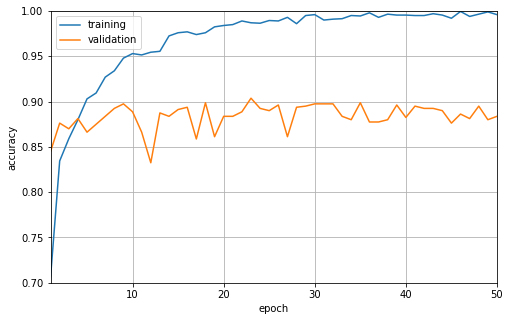

In [11]:
acc = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                    'training': history.history['acc'],
                    'validation': history.history['val_acc']})
ax = acc.ix[:,:].plot(x='epoch', figsize={5,8}, grid=True)
ax.set_ylabel("accuracy")
ax.set_ylim([0.7,1.0]);

In [12]:
max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history.history['val_acc']))
print('Maximum accuracy at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc))

Maximum accuracy at epoch 23 = 0.9038
